# COGS 108 - Demographic information and Mental health

# Overview

How do demographics affect one’s mental health? In order to identify the disadvantaged group and raise public awareness to ameliorate their living conditions, we explored data from the 2019 National Health Interview Survey, the most representative database of national health. 


In this project, we analyzed the correlation between a list of demographic factors and mental health issues (depression and anxiety) and developed a typology of adults who are vulnerable to mental health conditions based on their demographics. We hypothesize that some demographic factors will contribute to a higher probability of a mental health condition. To examine our hypothesis, we use methods like T-test, one-way ANOVA, and Tukey’s HSD on different demographics factors such as Gender, Sexual Orientation, BMI, Income, and Household Location. We also utilized Machine Learning to explore that if we can accurately predict mental health issues. 

# Names

- Adam Liu
- Siming Jin
- Xiaoye Zuo
- Derek Chen

<a id='research_question'></a>
# Research Question

Are demographic information like income, education level, race, and household region correlated with chronic mental health conditions like anxiety and depression in US adutls?

<a id='background'></a>

## Background & Prior Work

Mental health has become a serious problem in modern day America. According to a 2020 survey by the American Psychology Association, nearly 1 in 5 adults (19%) say their mental health is worse than it was at this time last year. Therefore, it would be benificial to the general public to explore the relationships between those mental health disease and sociodemographic factors.

In Noori & Janet's 2007 paper, the authors' explored the factors of age, gender, marital status, education, immigrant status, and income in young adults (16-24) and seniors (65+) with respect to depression. They found out that

    1. marital status does not affect depression status
    2. lowest rates of depression is associated with less than secondary school education, while the highest rate is associated with "other post-secondary" education
    3. people who were born in Canada has higher depression rate compared to residents who immigrated to Canada
    
Another paper by Nikolaos Koutsouleris et al. explored the use of machine learning models on predicting depression and psychosis, and found out that the models often outperform human pregnosis. 

References (include links):
- 1) [Stress in America 2020 Survey - APA](https://www.apa.org/news/press/releases/2020/10/stress-mental-health-crisis)
- 2) [Relation between depression and sociodemographic factors](https://link.springer.com/article/10.1186/1752-4458-1-4)
- 3) [Prediction Models of Funtional Outcomes for Individuals in the Clinical High-Risk State for Psychosis or With Recent-Onset Depression](https://jamanetwork.com/journals/jamapsychiatry/article-abstract/2707956)

# Hypothesis


We hypothesize that the following factor in ranking will contribute to a higher probabiltiy of a mental health condition:

    - lower income
    - lower education level
    - higher/lower than average BMI
    - minority race
    - poorer household region
    
due to the fact that they are usually the most vulnerable socioeconomic group. They often need to handle higher level of stress, possily due to financial/job/housing/healthcare insecurity.

# Dataset(s)

- Dataset Name: 2019 National Health Interview Survey
- Link to the dataset: https://www.cdc.gov/nchs/nhis/2019nhis.htm
- Number of observations: 31996

The NHIS is the annual cross-sectional health survey conducted by the Centers for Disease Control and Prevention. It surveys a wide range of health status and utilizations among population in the United States. We picked the adult subset because we think it would be more representative of the mental health condition in the United States. This data includes all the demographic informations of the survery taker and store them into categories for privacy issue, while also many different heath probelm inculding mental health and the frequceny of having these problems. Which later helps us to created a score system to determined mental health's correlation with other factor, where a higher score means that the sample has a worse mental health condition. 

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statsmodels.api as sm
import patsy
import sklearn.linear_model
import sklearn.ensemble
import sklearn.neural_network
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pandas.plotting import scatter_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# read in cleaned dataset
df = pd.read_csv("./datasets/adult_cleaned.csv")
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [4]:
sns.set(rc={"figure.figsize":(12, 5)})

# Data Cleaning

Steps:
1. Renaming columns based on codebook provided by CDC code book since the original columns names are really confusing<br>

2. Replace the value 5 in anxiety and depression frequency to 0<br>
These columns are how often the person feel worried, nervous, or anxious <br>
1-4 are range in “Daily”, “Weekly”, “Monthly”, “A few times in a year”<br>
5 in both anxiety and depression frequency means never experiencing the problem.<br>
3. Replace NAN in anxiety and depression level with 0<br>
1-3 are range in “A little”, “A lot”, “Somewhere in between a little and a lot”. <br>
4. Removing rows of ambiguous samples with responses, “I don’t know”, “not ascertained”, and “refused”, from the rest of dataset<br>
5. Encode all binary responses to 1/0 instead of 1/2 for yes/no. 
6. Reduce the number of categories for the education column to 3 because it had too many details. 
6. After this brief cleaning, there are 29504 samples left from the original dataset with 31997 samples. <br>

In [5]:
## YOUR CODE HERE

adult_df = pd.read_csv('./datasets/adult19.csv')

This dataset has very confusing attribute names. Renaming columns based on [codebook](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2019/adult-summary.pdf) provided by the CDC. 

In [6]:
need_cols = ['URBRRL', 'AGEP_A', 'SEX_A', 'EDUC_A', 'ANXEV_A', 'DEPEV_A',
             'NOTCOV_A', 'ANXFREQ_A', 'ANXLEVEL_A', 'DEPFREQ_A','DEPLEVEL_A',
             'ORIENT_A', 'MARITAL_A', 'AFVET_A', 'CITZNSTP_A', 'INCGRP_A', 'BMICAT_A']

In [7]:
subset_df = adult_df[need_cols]

In [8]:
subset_df.columns

Index(['URBRRL', 'AGEP_A', 'SEX_A', 'EDUC_A', 'ANXEV_A', 'DEPEV_A', 'NOTCOV_A',
       'ANXFREQ_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPLEVEL_A', 'ORIENT_A',
       'MARITAL_A', 'AFVET_A', 'CITZNSTP_A', 'INCGRP_A', 'BMICAT_A'],
      dtype='object')

In [9]:
subset_df.columns = ['urbanrural', 'age', 'sex', 'edu', 'anx_ever', 'dep_ever', 
                    'inscov', 'anx_freq', 'anx_level', 'dep_freq', 'dep_level', 
                    'orient', 'marital', 'military_ever', 'citizenship', 'income', 'bmi']

In [10]:
column_map = dict(zip(subset_df.columns, need_cols))

Column anx_freq and dep_freq (anxiety and depression frequency) encodes "never" as 5, replacing with 0.

In [11]:
subset_df = subset_df.replace({"anx_freq": {5: 0}, "dep_freq": {5: 0}})

In [12]:
subset_df.isna().any()

urbanrural       False
age              False
sex              False
edu              False
anx_ever         False
dep_ever         False
inscov           False
anx_freq         False
anx_level         True
dep_freq         False
dep_level         True
orient           False
marital          False
military_ever    False
citizenship      False
income           False
bmi              False
dtype: bool

Column anx_level (anxiety level) and dep_level (depression level) has NaN values. Replace them with 0 

In [13]:
subset_df.loc[:, 'anx_level'] = subset_df.loc[:, 'anx_level'].apply(lambda x : 0 if math.isnan(x) else x)

In [14]:
subset_df.loc[:, 'dep_level'] = subset_df.loc[:, 'dep_level'].apply(lambda x : 0 if math.isnan(x) else x)

In [15]:
subset_df['anx_level'].value_counts()

1.0    10849
0.0    10371
3.0     7974
2.0     2609
9.0       97
7.0       87
8.0       10
Name: anx_level, dtype: int64

Also in these columns, values 7, 8, and 9 means a response that's either 'i don't know' or refused to answer. Removing these samples from the dataset. 

In [16]:
subset_df = subset_df[(subset_df['anx_level'] < 7.0) & (subset_df['dep_level'] < 7.0)]
# less than 1% of the sample is removed.

In [17]:
column_map

{'urbanrural': 'URBRRL',
 'age': 'AGEP_A',
 'sex': 'SEX_A',
 'edu': 'EDUC_A',
 'anx_ever': 'ANXEV_A',
 'dep_ever': 'DEPEV_A',
 'inscov': 'NOTCOV_A',
 'anx_freq': 'ANXFREQ_A',
 'anx_level': 'ANXLEVEL_A',
 'dep_freq': 'DEPFREQ_A',
 'dep_level': 'DEPLEVEL_A',
 'orient': 'ORIENT_A',
 'marital': 'MARITAL_A',
 'military_ever': 'AFVET_A',
 'citizenship': 'CITZNSTP_A',
 'income': 'INCGRP_A',
 'bmi': 'BMICAT_A'}

Doing the same thing for the remaining columns that contains "don't know" answers.

In [18]:
subset_df = subset_df[(subset_df['sex'] <= 2) & (subset_df['edu'] <= 11) & 
          (subset_df['age'] <= 85) & (subset_df['anx_ever'] <= 2) & (subset_df['dep_ever'] <= 2) & 
          (subset_df['inscov'] <= 2) & (subset_df['orient'] <= 4) & (subset_df['marital'] <= 3) &
          (subset_df['military_ever'] <= 2) & (subset_df['citizenship'] <= 2) & (subset_df['bmi'] <= 4)]

Since there are many different categories in the education column, we reduce the coding to three main categories: 1 encodes for people without a college degree(high school or below), 2 indicates a college degree or equivalent, 3 stands for a professional degree (Master's, PhD, MD, JD..). The first, second, and third categories take up roughly 55%, 35%, and 10% of the entire data, which looks intuitive to us based on experience. 

In [19]:
def map_edu(x):
    if x in {0, 1, 2, 3, 4, 5}:
        return 1
    elif x in {6, 7, 8}:
        return 2
    return 3

In [20]:
subset_df['edu'] = subset_df['edu'].apply(map_edu)

In [21]:
subset_df['military_ever'] = subset_df['military_ever'].apply(lambda x : 0 if (x == 2) else x)

In [22]:
subset_df['anx_ever'] = subset_df['anx_ever'].apply(lambda x : 0 if (x == 2) else x)

In [23]:
subset_df['dep_ever'] = subset_df['dep_ever'].apply(lambda x : 0 if (x == 2) else x)

## Creating the score column

Since we are trying to determine the correlation between demographics information and mental health condition, we need a quantitative measure for mental health condition. We first explore variables related to mental health conditions

Since we have information on the level and frequency of anxiety and depression, we define a mental health score for each sample using the following. 

$\text{Score} = \text{anx_level} \times \text{anx_freq} + \text{dep_level} \times \text{dep_freq}$

where a higher score means that the sample has a worse mental health condition. This mental health score has several limitations. First of all, it's implying that a person who feels anxiety/depressed daily is 4 times worse than a person who feels so a few times a year. Secondly, we are assuming depression and anxiety plays the same role in a person's mental health condition, while in reality they're not equal. 


There are also several advantages of using this score. First of all, people who don't have any mental health illness will automatically get a score of 0. Moreover, a higher score means a person either has a high anxiety/depression level, or it means that the person feels depressed/anxiety more frequently. Both are indications of worse mental health conditions. Due to the limitation of the dataset, we will use this definition as a measure for mental health. 

In [88]:
def mh_score(row):
    return row['anx_level'] * row['anx_freq'] + row['dep_level'] * row['dep_freq']

In [89]:
df['score'] = df.apply(mh_score, axis=1)

Text(0.5, 1.0, 'Frequency Distribution of Mental Health Score')

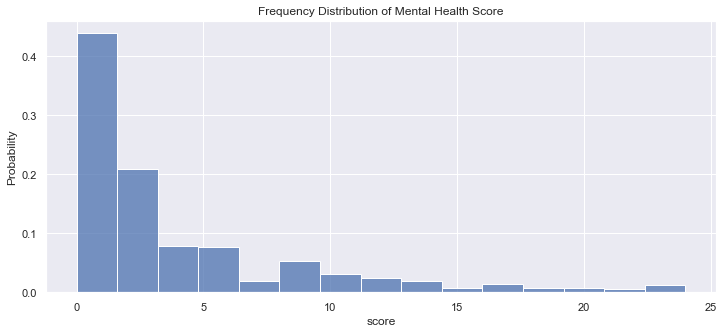

In [93]:
sns.histplot(data=df, x='score', stat="probability", bins=15)
plt.title("Frequency Distribution of Mental Health Score")

Since the score column is skewed, we use sklearn's standard scaler to normalize it and store in another column

In [91]:
# create new column using standard scaler
df['norm_score'] = sklearn.preprocessing.StandardScaler().fit_transform(df['score'].to_numpy().reshape(-1,1))

Text(0.5, 1.0, 'Frequency Distribution of Normalized Mental Health Score')

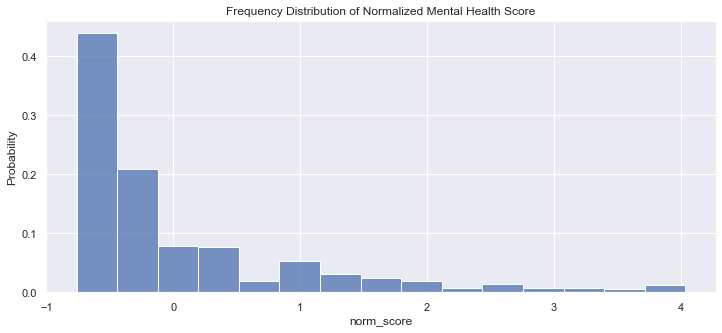

In [92]:
sns.histplot(data=df, x='norm_score', stat="probability", bins=15)
plt.title("Frequency Distribution of Normalized Mental Health Score")

We also create a binary variable indicating that if a sample has > 0 mental health score, so that we can frame our problem as both regression and classfication problem. 

In [29]:
df['mh_ever'] = df['score'].apply(lambda x : x > 0)

Text(0.5, 1.0, 'Ever Had Mental Health Issues')

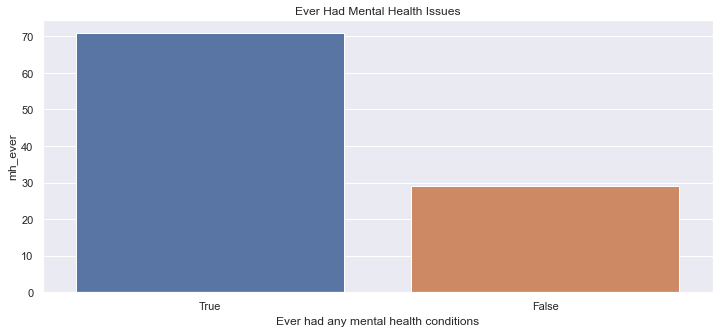

In [98]:
sns.barplot(x="mh_ever", y="mh_ever", data=df, estimator=lambda x: len(x) / len(df) * 100, order=[True, False])
plt.xlabel('Ever had any mental health conditions')
plt.title('Ever Had Mental Health Issues')

Surprisingly, more often than not, people have reported that they have at least some mental health issues like anxiety and depression. 

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [31]:
# read in cleaned dataset
df = pd.read_csv("./datasets/adult_cleaned.csv")
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

## EDA

In [32]:
df.columns

Index(['urbanrural', 'age', 'sex', 'edu', 'inscov', 'anx_freq', 'anx_level',
       'dep_freq', 'dep_level', 'orient', 'marital', 'military_ever',
       'citizenship', 'income', 'bmi', 'score', 'lgbt', 'mh_ever', 'urban'],
      dtype='object')

In [33]:
df.head()

,urbanrural,age,sex,edu,inscov,anx_freq,anx_level,dep_freq,dep_level,orient,marital,military_ever,citizenship,income,bmi,score,lgbt,mh_ever,urban
0,4,28,2,2,2,1,2.0,0,0.0,2,1,0,1,3,2,2.0,0,True,False
1,4,72,1,1,2,1,1.0,1,1.0,2,1,1,1,3,3,2.0,0,True,False
2,4,60,1,2,2,0,0.0,1,1.0,2,1,1,1,5,4,1.0,0,True,False
3,1,60,1,1,2,3,2.0,4,2.0,2,1,0,1,1,4,14.0,0,True,True
4,1,78,1,1,2,1,2.0,1,2.0,2,1,1,1,2,4,4.0,0,True,True


## Score
* Type: Numeric, continuous
* Description: mental health score, defined as $\text{Score} = \text{anx_level} \times \text{anx_freq} + \text{dep_level} \times \text{dep_freq}$

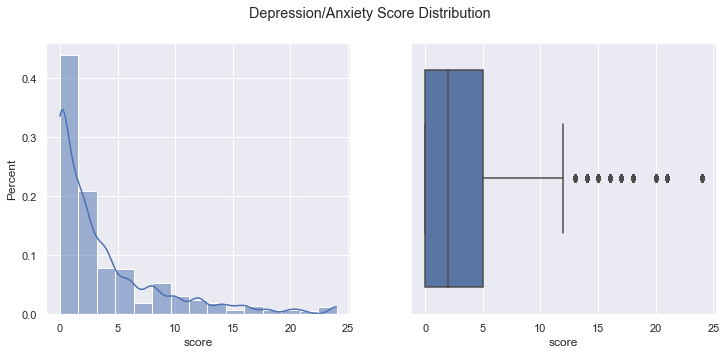

In [34]:

fig, axes = plt.subplots(1, 2)
sns.histplot(data=df, x='score', bins=15, kde=True, ax = axes[0], stat="probability").set_ylabel('Percent')
plt.suptitle('Depression/Anxiety Score Distribution')
sns.boxplot(data=df, x='score', ax = axes[1])
fig.show()

In [35]:
def get_outliers(col):
    IQR = col.quantile(q=0.75) - col.quantile(q=0.25)
    return col[np.abs(col - col.mean()) > 1.5 * IQR]

The resulting distribution is extremely right-skewed, which is expected since most samples in this dataset has no mental health issues. 

In [36]:
get_outliers(df['score'])

3        14.0
26       14.0
34       16.0
36       13.0
38       14.0
         ... 
29461    12.0
29483    24.0
29485    16.0
29486    12.0
29498    18.0
Name: score, Length: 2807, dtype: float64

In [37]:
df['score'].std()

5.0015226397554855

2807 outliers are in this column using the 1.5*IQR rule. This is due to the fact that our distribution is too right-skewed, with most of the samples concentrated in the 0-5 range. As a result, any sample with > ~9 score is considered an outlier

## Age
* Type: numeric, discrete
* Description: age

Text(0.5, 1.0, 'Age Distribution')

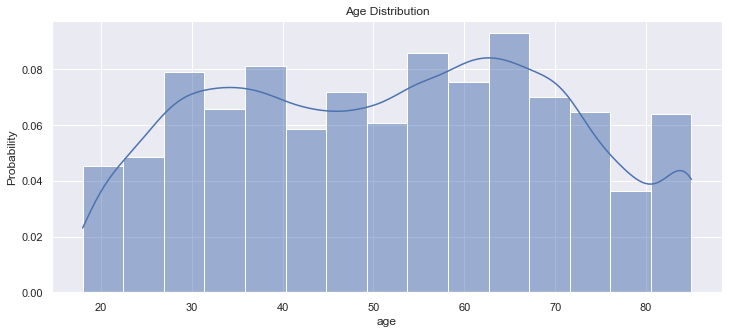

In [38]:
ax = sns.histplot(x = 'age', data = df, stat="probability", bins = 15, kde=True)
ax.set_title('Age Distribution')

The age column has a roughly uniform distribution, with most survey participants' age around 20-80. Each age bin contains roughly the same number of samples. Since the survey only has samples from age 18+, relatively few people are younger than 20 years old. There is a roughly equal probability for each age range/bin. 

In [39]:
get_outliers(df['age'])

Series([], Name: age, dtype: int64)

Using the $1.5 \times IQR$ definition for outliers, the age column does not have any outlier.

## Regional Information: Urban/Rural
* Type: Categorical
* Description: Describe the survey participants' urban-rural classification according to 2013 [NCHS](https://www.cdc.gov/nchs/index.htm)
* Encoding
    - 1 --> Large central metro
    - 2 --> Large fringe metro
    - 3 --> Medium and small metro
    - 4 --> Nonmetropolitan

Text(0.5, 1.0, 'Urban/Rural Breakdown')

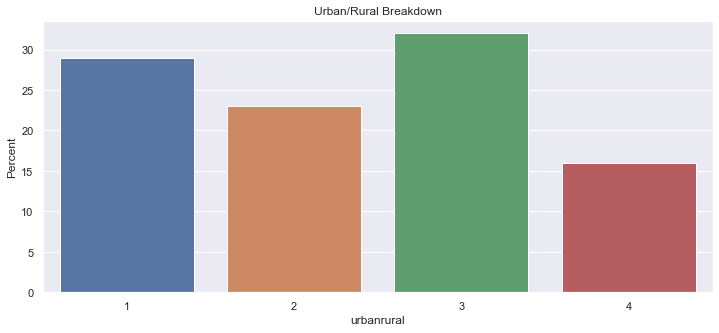

In [40]:
ax = sns.barplot(x="urbanrural", y="urbanrural", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Urban/Rural Breakdown')

From the graph, we could see that most people surveyed live in metro areas with more than 25% reporting to be in large central metro. This attribute is of our interest because living in the city can be both rewarding and stressful compared to life in the countryside. Does people live in the metropolitan area feel more anxious and depressed? Does the size of the metro influence the mental health score?

## Gender
* Type: Categorical
* Description: Sex of survey participants
* Encoding
    - 1 --> Male
    - 2 --> Female

Text(0.5, 1.0, 'Gender Breakdown')

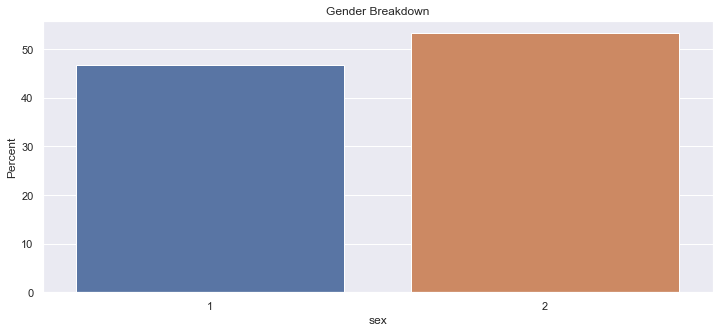

In [95]:
ax = sns.barplot(x="sex", y="sex", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Gender Breakdown')

We can see from out plot that around 46% of the survey response are from male, while 53% is from female. Notably, according to the [2020 US census](https://www.census.gov/quickfacts/fact/table/US/LFE046219), 50.8% of all US population are female. This suggests that our dataset is representative of the total population.

## Education Level
* Type: Categorical
* Description: Education level of survey participant
* Encoding
    - 1 --> No college degree
    - 2 --> Bachelor's degree
    - 3 --> Professional degree (masters, Ph.D., or equivalent)

Text(0.5, 1.0, 'Education Level Breakdown')

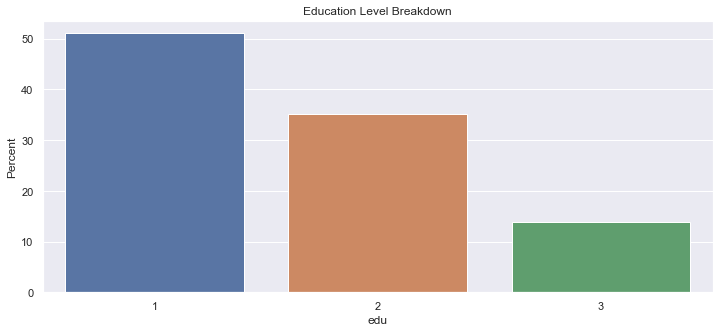

In [42]:
ax = sns.barplot(x="edu", y="edu", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Education Level Breakdown')

Not surprisingly, 'no college degree' is the most frequent category at about 51%, with bachelor's being the second frequent. A professional degree is significantly rarer at only 13%. Note that if "bachelor's or above" is a cateogry, it would account for 49% of all samples. 

## Anxiety Level and Depression Level
* Type: Categorical
* Descrption: Self-reported anxiety / depression level
* Encoding
    - 0 ---> no anxiety reported
    - 1 ---> "A little"
    - 2 ---> "Between a little and a lot"
    - 3 ---> "A lot"

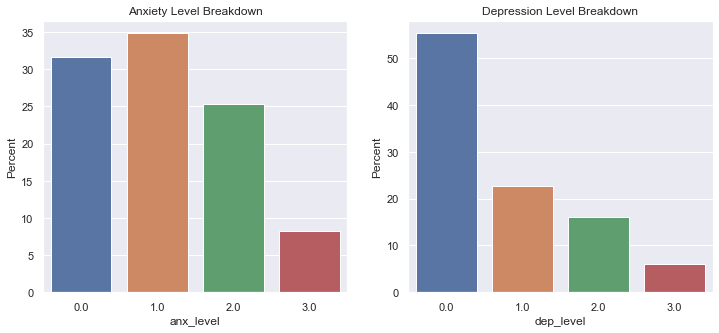

In [43]:
fig, axes =plt.subplots(1,2)
sns.barplot(x="anx_level", y="anx_level", data=df, estimator=lambda x: len(x) / len(df) * 100, ax = axes[0]).set(ylabel="Percent")
axes[0].set_title('Anxiety Level Breakdown')
sns.barplot(x="dep_level", y="dep_level", data=df, estimator=lambda x: len(x) / len(df) * 100, ax = axes[1]).set(ylabel="Percent")
axes[1].set_title('Depression Level Breakdown')
fig.show()

In both graphs, most people show little or no anixety/depression. However, from the plots, participants tend to be more anxious than depressesd. 

## Anxiety Frequency and Depression Frequency
* Type: Categorical
* Description: Response to survey question: How often do you feel anxiety / depressed? Would you say daily, weekly, monthly, a few 
times a year, or never? 
* Encoding
    - 0 ---> never
    - 1 ---> A few times a year
    - 2 ---> Monthly
    - 3 ---> Weekly
    - 4 ---> Daily

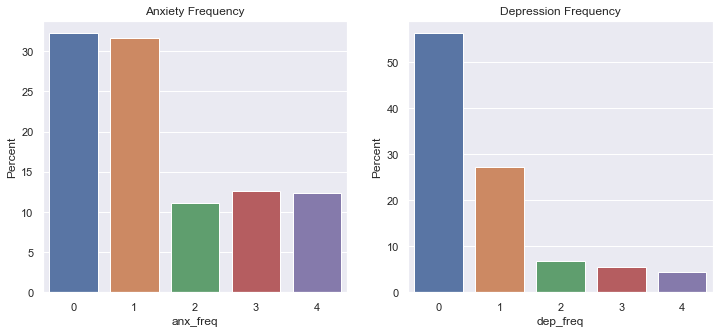

In [44]:
fig, axes =plt.subplots(1,2)
sns.barplot(x="anx_freq", y="anx_freq", data=df, estimator=lambda x: len(x) / len(df) * 100, ax = axes[0]).set(ylabel="Percent")
axes[0].set_title('Anxiety Frequency')
sns.barplot(x="dep_freq", y="dep_freq", data=df, estimator=lambda x: len(x) / len(df) * 100, ax = axes[1]).set(ylabel="Percent")
axes[1].set_title('Depression Frequency')
fig.show()

We can see from our plots that most people surveyed don't experience anxiety or depression. However, a lot more people reported feeling anxious than those who feel depressed. In general, both frequency counts have right-skewed distributions.

## Insurance Coverage
* Type: Categorical
* Descrption: Medical insurance coverage status
* Encoding
    - 1 ---> not covered
    - 2 ---> covered

Text(0.5, 1.0, 'Medical Insurance Coverage')

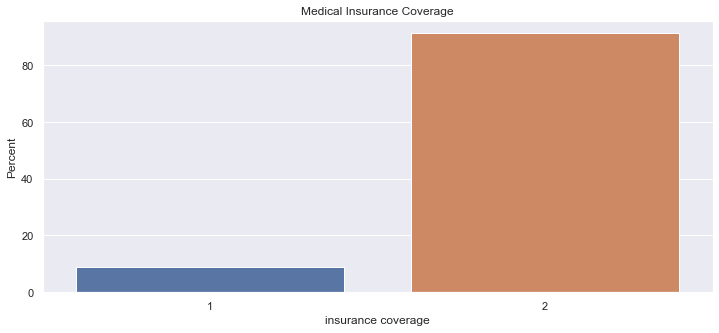

In [45]:
ax_ins = sns.barplot(x="inscov", y="inscov", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax_ins.set(ylabel="Percent", xlabel = 'insurance coverage')
ax_ins.set_title('Medical Insurance Coverage')

Most people are covered with some medical insurance. We included this variable since that whether or not people can get affordable care can affect their mental health conditions. 

## Sexual Orientation
* Type: Categorical
* Description: Sexual orientation
* Encoding
    - 1 ---> Gay/Lesbian
    - 2 ---> Straight
    - 3 ---> Bisexual
    - 4 ---> Something else

Text(0.5, 1.0, 'Sexual Orientation Breakdown')

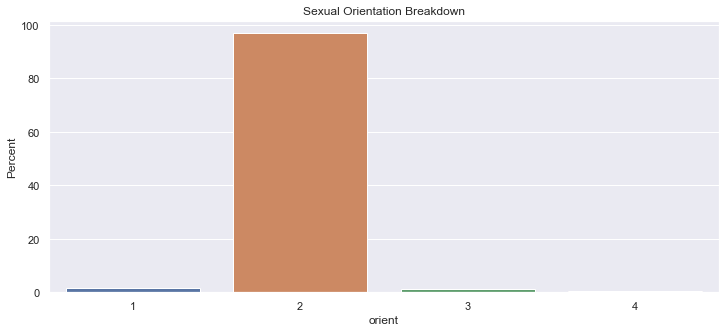

In [46]:
ax = sns.barplot(x="orient", y="orient", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Sexual Orientation Breakdown')

We can see that 95% of the people surveyed are straight, which aligns with the overall sexuality percentage in the US. According to [some sources](https://www.nami.org/Your-Journey/Identity-and-Cultural-Dimensions/LGBTQI), LGBTQ teens are at higher risk of suicide thoughts and attempts due to a lack of mental support, so it's meaningful to look at the potential association between sexual orientation and mental health conditions. 

## Marital
* Type: Categorical
* Description: Marital status
* Encoding
    - 1 ---> married
    - 2 ---> living with partner together as unmarried couple
    - 3 ---> Neither

Text(0.5, 1.0, 'Marital Status Breakdown')

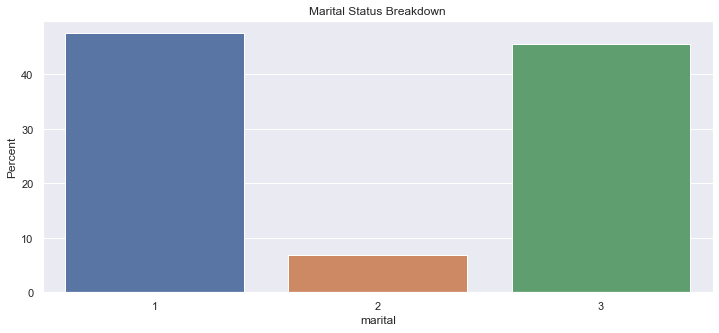

In [47]:
ax_marital = sns.barplot(x="marital", y="marital", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax_marital.set(ylabel="Percent")
ax_marital.set_title('Marital Status Breakdown')

There is approximately the same number of people staying single and entering marriages. Based on the paper, (https://users.wfu.edu/simonr/pdfs/Simon%20AJS%202002.pdf), married groups have better mental health conditions than the unmarried groups. In this project, We are also interested to see whether our model confirms this finding.

## military_ever
* Type: Categorical
* Description: response to survey question: Did you ever serve on active duty in the U.S. Armed Forces, military Reserves, 
or National Guard?  
* Encoding
    - 0 ---> No
    - 1 ---> Yes

Text(0.5, 1.0, 'Military Hisotry Breakdown')

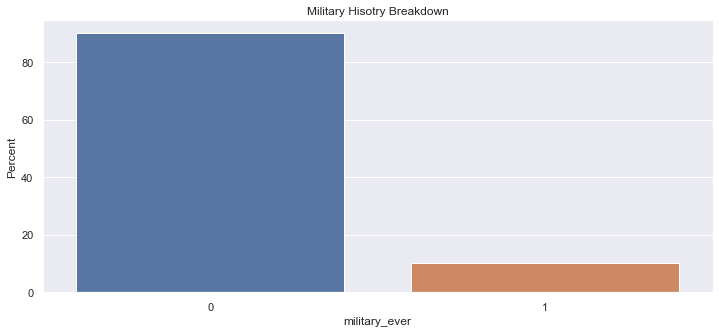

In [48]:
ax_military = sns.barplot(x="military_ever", y="military_ever", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax_military.set(ylabel="Percent")
ax_military.set_title('Military Hisotry Breakdown')

Less than 10% of samples indicated that they have served in the military. A military career can be potentially associated with worse mental health conditions due to severe trainings and war situations. Many military soldiers retired with mental disorders like PTSD.

## citizenship
* Type: Categorical
* Description:Citizenship status
* Encoding
    - 0: No, not a citizen of United States
    - 1: Yes, a citizen of United States.

Text(0.5, 1.0, 'US Citizenship Status Breakdown')

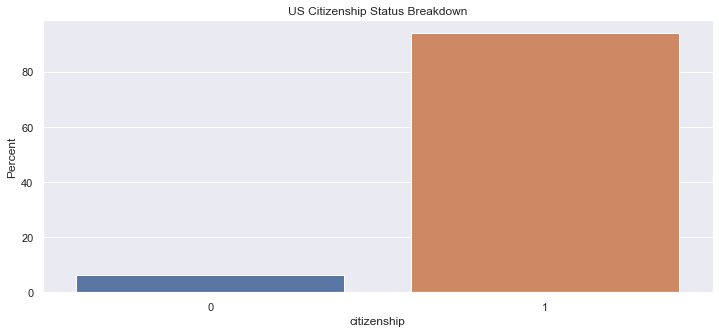

In [49]:
ax_citizen = sns.barplot(x="citizenship", y="citizenship", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax_citizen.set(ylabel="Percent")
ax_citizen.set_title('US Citizenship Status Breakdown')

Most people surveyed are citizen of the US. We should look at potential association between citizenship and mental wellbeing because people like illegal immigrants might have worse mental health conditions.

## income
* Type: Categorical
* Description: family income of sample adult
* Encoding
    - 1->\$0 to 34,999
    - 2->\$35,000 to 49,999
    - 3->\$50,000 to 74,999 
    - 4->\$75,000 to 99,999
    - 5->\$100,000 or greater 

Text(0.5, 1.0, 'Household Income Breakdown')

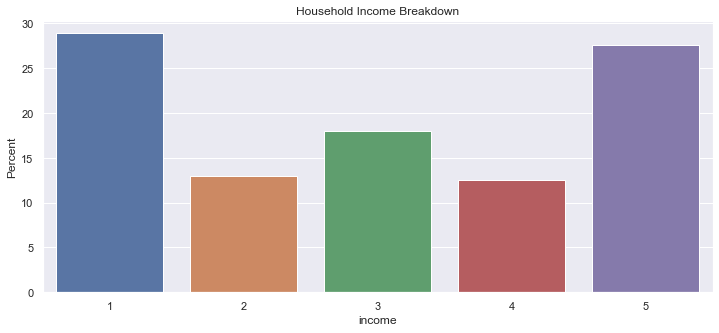

In [50]:
ax_income = sns.barplot(x="income", y="income", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax_income.set(ylabel="Percent")
ax_income.set_title('Household Income Breakdown')

The income variable resembles a bimodal distribution, with more than 8000 samples beloning in the poorest and the richest category. Income should also be a significant predictor of mental health, since we assume more well off families have better mental health conditions.

## bmi
* Type: Categorical
* Description: Categorical body mass index
* Encoding
    - 1->Underweight
    - 2->Healthy weight
    - 3->Overweight 
    - 4->Obese 


Text(0.5, 1.0, 'BMI Breakdown')

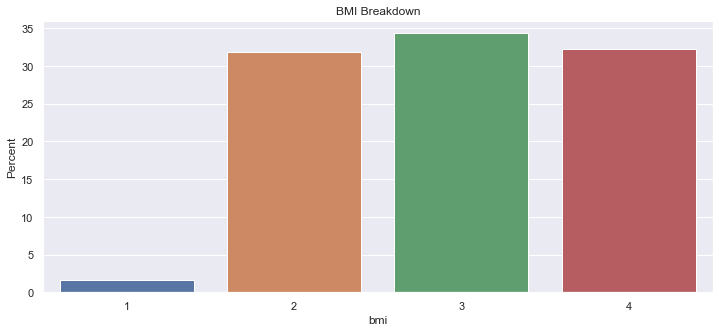

In [51]:
ax_bmi = sns.barplot(x="bmi", y="bmi", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax_bmi.set(ylabel="Percent")
ax_bmi.set_title('BMI Breakdown')

From the graph, we can see that the vast majority of participants are either overweight or obese, suggesting that there might be an obesity problem in the sample dataset. The study (https://pubmed.ncbi.nlm.nih.gov/29289809/) indicates that there is a strong correlation between abnormal body weight and mental health issues. We will also try to substantiate this finding in this project.

## Potential association between variables

We look at the following variable pairs for potential relationships:
1. education, sex, insurance coverage vs. income
2. age, sex, education, insurance coverage, marital status, sexual orientation, military, income vs. score.

### Correlation matrix

In [52]:
df.corr()['income']

urbanrural      -0.127932
age             -0.117478
sex             -0.094054
edu              0.375434
inscov           0.163701
anx_freq        -0.071935
anx_level       -0.071556
dep_freq        -0.180221
dep_level       -0.154644
orient          -0.034901
marital         -0.411476
military_ever    0.009670
citizenship      0.064840
income           1.000000
bmi             -0.070100
score           -0.160445
lgbt            -0.030203
mh_ever         -0.012147
urban            0.126545
Name: income, dtype: float64

### Association between education and income

In [53]:
income_edu = df[['income', 'edu']].copy()
income_edu.corr()

,income,edu
income,1.000000,0.375434
edu,0.375434,1.000000


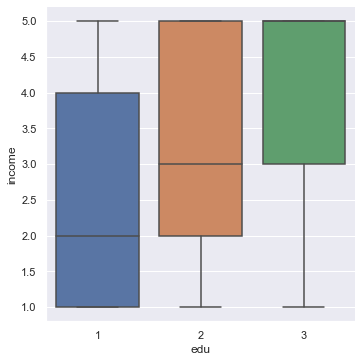

In [54]:
sns.catplot(x="edu", y="income", kind="box", data=df)


### Association between sex and income

In [55]:
income_sex = df[['income', 'sex']].copy()
income_sex.corr()

,income,sex
income,1.000000,-0.094054
sex,-0.094054,1.000000


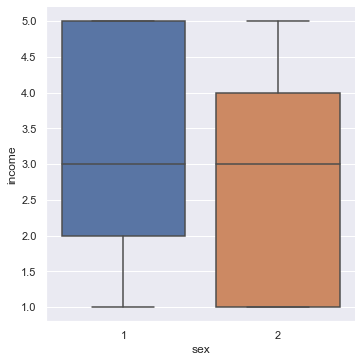

In [56]:
sns.catplot(x="sex", y="income", kind="box", data=df)

### Association between insurance coverage and income

In [57]:
income_ins = df[['income', 'inscov']].copy()
income_ins.corr()

,income,inscov
income,1.000000,0.163701
inscov,0.163701,1.000000


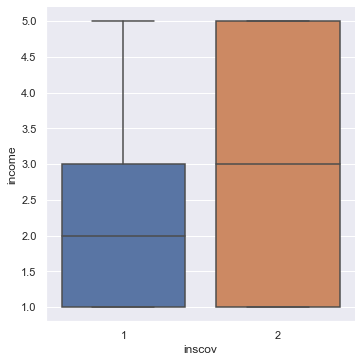

In [58]:
sns.catplot(x="inscov", y="income", kind="box", data=df)

From the correlation coefficients, we can see that education has the highest correlation with income. (we skipped marital status since the income variable denotes family income, and married couples have ~2x the income as unmarried ones) This aligns with our assumption that a better education will result in higher income. 

Sex is slightly correlated with income with a r=-0.09. 

Finally, insurance coverage is slightly positively correlated with income, with higher income families more likely to have medical insurance coverage. We can also see from the box plot that people with insurance coverage has higher median income than non-insured ones.

### Correlation coefficient for score

In [59]:
df.corr()['score']

urbanrural       0.030173
age             -0.114995
sex              0.125775
edu             -0.056256
inscov          -0.029351
anx_freq         0.816019
anx_level        0.749101
dep_freq         0.834451
dep_level        0.753815
orient           0.087515
marital          0.115489
military_ever   -0.041297
citizenship      0.069695
income          -0.160445
bmi              0.033985
score            1.000000
lgbt             0.122029
mh_ever          0.489024
urban           -0.023525
Name: score, dtype: float64

### Association between income and score

In [60]:
income_score = df[['income', 'score']].copy()
income_score.corr()

,income,score
income,1.000000,-0.160445
score,-0.160445,1.000000


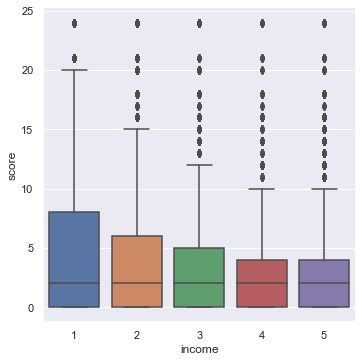

In [61]:
sns.catplot(x="income", y="score", kind="box", data=df)

From the boxplots above, we can see that as income increase, less people have higher mental risks. All boxplots seem to have similar medians, indicating that all income groups have similar score distributions for the lower 50 percentile. 

### Association between BMI and depression score

In [62]:
bmi_dep = df[['bmi', 'score']].copy()
bmi_dep.corr()

,bmi,score
bmi,1.000000,0.033985
score,0.033985,1.000000


The correlation between BMI and depression score is 0.033, so there isn't a strong correlation between these two attributes.

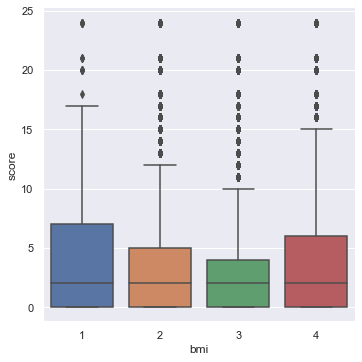

In [63]:
sns.catplot(x="bmi", y="score", kind="box", data=df)

From the boxplots above, we can tell that people who are obese or underweight have higher depression/anxiety score for the upper 50 percentile. This makes sense since people who expereince depression/anxiety usually suffer from eating disorders as a result.. 

## Mental Health and Gender

We first explore the effect of gender on mental health score. 

In [64]:
male_mh_score = df[df['sex'] == 1]['score']
female_mh_score = df[df['sex'] == 2]['score']

Text(0.5, 1.0, 'Mental health score by gender')

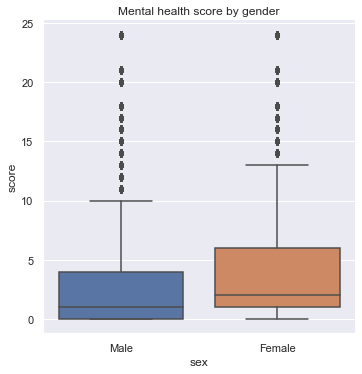

In [65]:
sns.catplot(kind='box', x='sex',y='score',data=df)
ax = plt.gca()
ax.set_xticklabels(labels=['Male','Female'])
plt.title('Mental health score by gender')

From the graph we can see roughly that females have higher mental health score (worse condition) than male in our dataset. Is the difference statistically significant? Here we will use an independent samples t test. Since our data came from a national health survey. Samples in our dataset can be considered to be  independent

In [66]:
sm.stats.ttest_ind(male_mh_score, female_mh_score, alternative='smaller')

(-21.77625521792158, 1.2939376572161482e-104, 29502.0)

With a p value in the order of 10e-104, we can see that the difference between male and female mental health score is statistically significant. Females have worse mental conditions than men. 

## Mental Health and Sexual Orientation

In this section, we explore the effect of being LGBT on mental health conditions. Since we have 4 categories of sexual orientation (straight, bisexual, gay/lesbian, others), we encode them into a binary variable: LGBT or non-LGBT, so that we can see the effect more clearly.

In [67]:
LGBT_score = df[df['orient'] != 2]['score']
non_LGBT_score = df[df['orient'] == 2]['score']

In [68]:
# create new binary variable based on LGBT or straight
df['lgbt'] = df['orient'].apply(lambda x : 1 if x != 2 else 0)

Text(0.5, 1.0, 'Mental Health Score by Sexual Orientation')

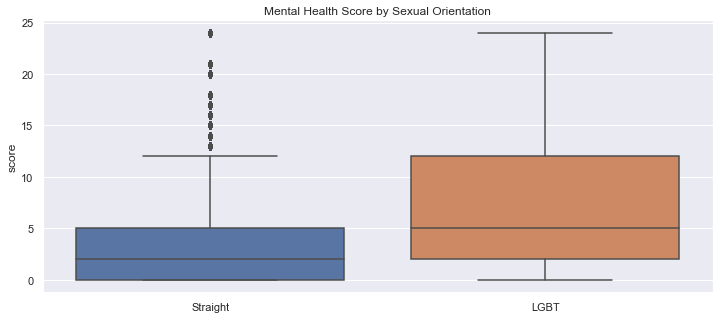

In [69]:
# graph new column against mental health score
sns.boxplot(x='lgbt', y='score', data=df)
ax = plt.gca()
ax.set_xticklabels(['Straight', 'LGBT'])
ax.set_xlabel('')
plt.title("Mental Health Score by Sexual Orientation")

From the box plot, we see that LGBT population has a higher median, 25% and 75% percentile than the straight population. We again use t test to verify statistical significance

In [70]:
t, p, dof = sm.stats.ttest_ind(LGBT_score, non_LGBT_score, alternative='larger')
t, p

(21.117788352933935, 1.4587527160851227e-98)

Again, the p value we get is extremely small, suggesting that the difference is statistically significant. The LGBT population does appear to have a higher mean mental health score than straight population. 

## Mental Health and BMI (body weight)
In our EDA, we explored the relationship between BMI and mental health score. We hypothesized that underweight and overweight people are more likely (i.e. has higher mental health score than) people with normal bodyweight.

In [71]:
underweight_scores = df[df['bmi'] == 1]['score']
normal_scores = df[(df['bmi'] == 2)]['score']
overweight_scores = df[(df['bmi'] == 4)| (df['bmi'] == 3)]['score']

Text(0.5, 1.0, 'Mental Health Score by Bodyweight')

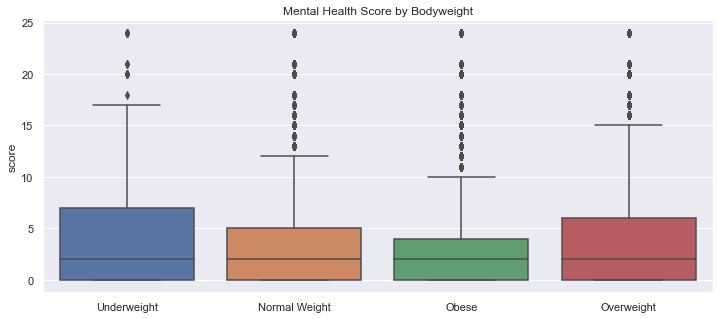

In [72]:
sns.boxplot(x='bmi', y='score', data=df)
ax = plt.gca()
ax.set_xticklabels(['Underweight', 'Normal Weight', 'Obese', 'Overweight'])
ax.set_xlabel('')
plt.title("Mental Health Score by Bodyweight")

We can see from the graph that underweight and overweight people generally have higher mental health score than normal weight/obese people. We can test for our hypothesis using one way ANOVA.

In [73]:
scipy.stats.f_oneway(overweight_scores, normal_scores, underweight_scores)

F_onewayResult(statistic=4.532796816062099, pvalue=0.010758055035707459)

With a 0.01 p value, we reject our null hypothesis. Bodyweight does seem to affect mental health score. However, an ANOVA does not tell us where the effect came from. Therefore, we perform a [Tukey's HSD test](https://en.wikipedia.org/wiki/Tukey%27s_range_test) to identify effect source. 

In [74]:
# perform Tukey's HSD. Here, group 1 is underweight, group 2 is considered normal bmi, group 3 and 4 are obese
# /overweight
print(pairwise_tukeyhsd(df['score'], df['bmi']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.6857 0.0193 -1.2922 -0.0791   True
     1      3  -0.9983  0.001 -1.6038 -0.3928   True
     1      4  -0.1819 0.8525 -0.7883  0.4245  False
     2      3  -0.3127  0.001 -0.4964  -0.129   True
     2      4   0.5037  0.001  0.3173  0.6902   True
     3      4   0.8164  0.001  0.6334  0.9994   True
----------------------------------------------------


From the HSD result, we confirmed the fact that being overweight/underweight can affect mental health conditions, since the null hypothesis is rejected for all pairs of underweight/overweight vs. normal bmi. This suggests that under/overweight people have worse mental health conditions than people with normal bodyweight.

## Mental Health and Income

We expect to see that higher income will associate with a lower mental health score, since people with higher income typically have better living conditions. Again, we have 5 income groups encoded ordinally, so we will use a one way ANOVA to test for mean difference. 

In [75]:
# aggregate score by income groups, then conduct one way ANOVA
income_groups = df.groupby('income').agg(list)['score']

scipy.stats.f_oneway(*income_groups)

F_onewayResult(statistic=209.69529595827885, pvalue=1.032556098074986e-177)

This is an extremely small p value, so we are really confident that mean mental health scores is not the same across all income groups. To identify effect source, we again conduct a pairwise Tukey's HSD test. 

In [76]:
print(pairwise_tukeyhsd(df['score'], df['income']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.9616  0.001 -1.2235 -0.6997   True
     1      3  -1.5278  0.001 -1.7628 -1.2927   True
     1      4  -1.8253  0.001 -2.0902 -1.5604   True
     1      5  -2.0514  0.001   -2.26 -1.8429   True
     2      3  -0.5661  0.001 -0.8514 -0.2809   True
     2      4  -0.8637  0.001  -1.174 -0.5534   True
     2      5  -1.0898  0.001 -1.3536  -0.826   True
     3      4  -0.2976 0.0388 -0.5856 -0.0096   True
     3      5  -0.5237  0.001 -0.7609 -0.2865   True
     4      5  -0.2261 0.1409 -0.4929  0.0407  False
----------------------------------------------------


Apart from the richest 2 income groups, the mean differences are all statistically significant. Notably, group 1 and 5 (richest and poorest groups) has the largest mean difference at 2.05, while the smallest mean difference is group 4 and 5 at only 0.22. 

## Mental Health and Household Location

Household location is another potential predictor of mental health. Here, we expect that people who live in large urban areas are more likely to have mental health issues than people who live in rural areas due to their fast-paced lifestyles. We have 5 classes of household location. Here, we cast them into a binary variable of urban or rural. 

In [77]:
df['urban'] = df['urbanrural'].apply(lambda x : x != 4)
rural_scores = df[df['urbanrural'] == 4]['score']
urban_scores = df[df['urbanrural'] != 4]['score']

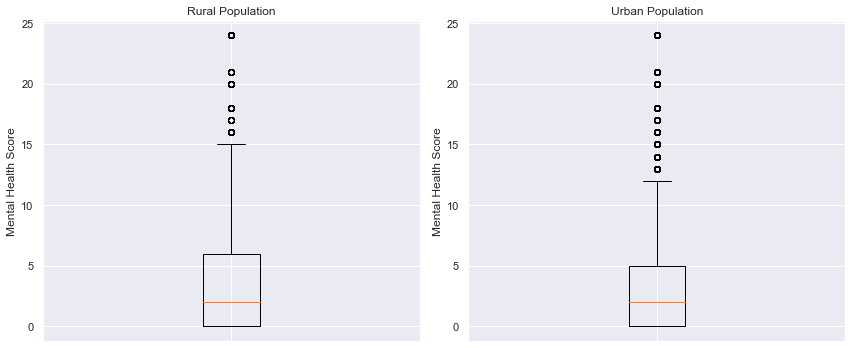

In [78]:
# display mental health score between urban and rural populations
f, a = plt.subplots(1,2)
a = a.flatten()
a[0].boxplot(rural_scores)
a[0].set_xticklabels("")
a[0].set_title('Rural Population')
a[0].set_ylabel('Mental Health Score')
a[1].boxplot(urban_scores)
a[1].set_xticklabels("")
a[1].set_ylabel('Mental Health Score')
a[1].set_title('Urban Population')
plt.tight_layout()

We can see that contrary to our assumptions, rural population seems to have a slightly higher mental health scores. We test this hypothesis using independent samples t test.

In [79]:
t, p, dof = sm.stats.ttest_ind(rural_scores, urban_scores, alternative='larger')

t, p

(4.041883755904036, 2.6578971351769542e-05)

At a significance level of 0.05, the t test confirms that rural population has higher mean mental health score than the urban population, suggesting a worse mental health condition. 

## Machine Learning

In this section, we employ machine learning to see that if we can effectively predict mental health score using demographics information. To do this, we frame both a regression and a classification task. For regression, we aim to directly predict mental health score, which is a continuous variable. For classification task, we split the dataset into score < 2.0 (median score) and score > 2.0 category, yielding a balanced classification task. We also introduce another classification task that predicts between score = 0 and score > 0, which is slightly unbalanced but is more meaningful in predicting whether people **has** any mental health condition than using median threshold. 

To achieve the best possible performance on each model, we use a randomized search cross validation on all possible hyperparameters.

In [5]:
df['score'].describe()

count    29504.000000
mean         3.809145
std          5.001523
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max         24.000000
Name: score, dtype: float64

### Models
For regression task, we will compare performance between SGD regression, support vector regression (an extension of SVM clasifier), and random forest regressor (an extension of classifier countepart).

For classification tasks, we wil compare between Logistic Regression, SVM, Random Forest, and Multi-layer Perceptron. Since data to contain a lot of random noise, we expect ensemble methods like the random forest to achive better performance. 

In [6]:
df.columns

Index(['urbanrural', 'age', 'sex', 'edu', 'inscov', 'anx_freq', 'anx_level',
       'dep_freq', 'dep_level', 'orient', 'marital', 'military_ever',
       'citizenship', 'income', 'bmi', 'score', 'lgbt', 'mh_ever', 'urban'],
      dtype='object')

### Features
We incoorporate all features that might be useful in predicting mental health conditions. In our dataset, we have urban, age, sex, edu, inscov, marital, citizenship, income, bmi, and lgbt. Sexual orientation is skipped since it's already encoded as a binary variable in lgbt column. 

### Regression

In [7]:
# features in regression analysis
cols = ['age', 'income', 'inscov', 'urban', 'sex', 'edu','lgbt','bmi','marital']

# regressor candidates
regressors = [sklearn.linear_model.SGDRegressor(), sklearn.svm.SVR(), sklearn.ensemble.RandomForestRegressor()]

In [8]:
# hyperparameters for regressors
params = [{'penalty':['l1','l2','elasticnet'], 'loss': ['huber','squared_loss'], 
          'alpha':[10e-4,10e-3,10e-2,1,10]}, 
         {'kernel': ['rbf','linear','sigmoid'], 'C': [10e-4,10e-3,10e-2,1,10]}, 
         {'criterion': ['mse', 'mae'], 'max_features':['auto','sqrt','log2'], 'min_samples_split': [2,4,6]}]

In [9]:
# training and performance comparison
random_seed = np.random.randint(low=1)
best = []
for idx, rg in enumerate(regressors):
    print('Fitting',rg)
    param = params[idx] # hyperparameter grid
    gs = sklearn.model_selection.RandomizedSearchCV(estimator=rg, 
                                              param_distributions=param, 
                                              scoring=['r2','neg_mean_squared_error'],
                                              verbose=2,
                                              n_jobs=-1,
                                             refit='neg_mean_squared_error')
    train, test = sklearn.model_selection.train_test_split(df, test_size=0.2,random_state=random_seed)
    X_train = train[cols]
    Y_train = train['score']
    gs.fit(X_train, Y_train)
    best_rg = gs.best_estimator_
    # test best regressor on test set
    pred = best_rg.predict(test[cols])
    best.append(best_rg)
    print("MSE of best model:",sklearn.metrics.mean_squared_error(test['score'], pred))
    print()
    

Fitting SGDRegressor()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MSE of best model: 33.450927585910826

Fitting SVR()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MSE of best model: 25.965680488931085

Fitting RandomForestRegressor()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MSE of best model: 24.36179175139807



In [10]:
best # models producing best MSE

[SGDRegressor(alpha=10, penalty='l1'),
 SVR(C=10, kernel='linear'),
 RandomForestRegressor(criterion='mae', max_features='log2', min_samples_split=6)]

During the training process, most of the models converged in less than a minute. However, the SVR regressor with linear kernel ran for ~13 minutes before converging, suggesting our data is not linearly seperable. This prompted us to pick models like decision tree or random forest during the classfication task.

In the regression task, SVR regressor achieves similar performance to random forest regressor. However, the MSE is still quite high at ~24. Due to the limitations of our mental health score definition, this is expected. Therefore, we turn to the two binary classification tasks to see that if we can accurately predict classes.

## Classification Task

Before we start training, we transform all categorical (encoded ordinally) columns using a one hot encoder. This because all of our categorical variables have no quantitative relationships between them. For example, the income groups were encoded as integer 1 - 5. However, the highest income group is not necessarily 5 times richer than the lowest one. For this reason, one hot encoding is a more accurate way of encoding our categorical information. 

In [11]:
cols = ['age', 'income', 'inscov', 'urban', 'sex', 'edu','lgbt','bmi','marital'] # features
cat_cols = ['income', 'inscov', 'urban', 'sex', 'edu','lgbt','bmi','marital'] # categorical features
onehot = sklearn.preprocessing.OneHotEncoder()
clf_df = df[cols].copy() # copy all features into a new df so we do not mess up our dataset

In [12]:
clf_df['mh_ever'] = df['mh_ever'].copy() # copy first target variable. is the score > 0?
clf_df['score'] = df['score'].copy()

In [13]:
# construct second target label. is the score in the top 50%?
median_score = df['score'].median()
clf_df['top50'] = clf_df['score'].apply(lambda x : x > median_score)

In [14]:
cat_df = pd.DataFrame.sparse.from_spmatrix(onehot.fit_transform(clf_df[cat_cols])) # use one hot encoding for all categorical columns
cat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


The onehot encoding converted our 8 categorical columns into 22. Since we only have one numerical feature (age), we will merge that with all the categorical ones to form our feature matrix. T

In [15]:
cat_df['age']  = clf_df['age'].copy()

Finally, we copy over both targets so that we can start training our models

In [16]:
cat_df['target1'] = clf_df['mh_ever'].copy()
cat_df['target2'] = clf_df['top50'].copy()

In [17]:
cat_df.head() # all features + 2 targets

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,age,target1,target2
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,28,True,False
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,72,True,False
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,60,True,False
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,60,True,True
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,78,True,True


The resulting matrix has 26 columns with 2 targets. 

### Predicting Target 1


In [18]:
cat_df['target1'].value_counts()

True     20891
False     8613
Name: target1, dtype: int64

As we can see, target 1 is highy unbalanced. However, it is significant since it's defined by whether a person will suffer from anxiety or depression at all. 

In [19]:
# classification on target1
random_seed = np.random.randint(0,100)
clf_list = [sklearn.linear_model.LogisticRegression(class_weight='balanced'), 
            sklearn.svm.SVC(), sklearn.ensemble.RandomForestClassifier(), 
      sklearn.neural_network.MLPClassifier()]
param_list = [{'C': [10e-4, 10e-3,10e-2,1,100], 'solver':['saga','lbfgs']},              
              {'kernel': ['linear','rbf','sigmoid'],'C': [10e-4, 10e-3,10e-2,1,100]}, 
             {'criterion': ['gini','entropy'], 'max_features':['auto','sqrt','log2'], 'min_samples_split': [2,4,6,8]},
             {'activation': ['relu','tanh','logistic'],
              'hidden_layer_sizes': [(1,15), (2, 6)],'alpha': [0.0001,0.001,0.1,1,10]}]

best_clf = []

for idx, clf in enumerate(clf_list):
    print('Fitting', clf)
    param = param_list[idx]
    train, test = sklearn.model_selection.train_test_split(cat_df, test_size = 0.2, random_state=random_seed)
    gs = sklearn.model_selection.RandomizedSearchCV(estimator=clf, 
                                                    param_distributions=param,scoring='accuracy',
                                                    refit=True,
                                                   verbose=1, n_jobs=-1)
    # drop target columns so we have X
    X_train = train.drop(['target1','target2'], axis=1)
    y_train = train['target1']
    # do the same for test set
    X_test = test.drop(['target1','target2'],axis=1)
    y_test = test['target1']
    # randomized gridsearch on all params
    gs.fit(X_train, y_train)
    pred_test = gs.best_estimator_.predict(X_test) # predicted test set labels
    best_clf.append(gs.best_estimator_) # store best estimator so we can see its hyperparameters
    # show classification report on best model 
    print(sklearn.metrics.classification_report(y_test, pred_test))
    print()

Fitting LogisticRegression(class_weight='balanced')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       False       0.36      0.58      0.45      1716
        True       0.77      0.59      0.67      4185

    accuracy                           0.58      5901
   macro avg       0.57      0.58      0.56      5901
weighted avg       0.65      0.58      0.60      5901


Fitting SVC()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      1716
        True       0.71      1.00      0.83      4185

    accuracy                           0.71      5901
   macro avg       0.35      0.50      0.41      5901
weighted avg       0.50      0.71      0.59      5901


Fitting RandomForestClassifier()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       

Random Forest classifier produced the best prediction accuracy at 70%, with an f1 score of 0.59. Considering that we only have 2 classes to predict from, this is fairly decent performance -- given demographics information like age, income group, etc., we have about 70% chance of predicting whether that person has had anxiety or depression. 

In [20]:
# hyperparameters with the best performance
best_clf 

[LogisticRegression(C=0.01, class_weight='balanced', solver='saga'),
 SVC(C=0.01, kernel='linear'),
 RandomForestClassifier(min_samples_split=8),
 MLPClassifier(alpha=1, hidden_layer_sizes=(1, 15))]

### Predicting Target 2

In [21]:
cat_df['target2'].value_counts()

False    16917
True     12587
Name: target2, dtype: int64

Target 2 is well-balanced since we defined it as "if the mental health score is higher than the median". This variable will predict if the person has a higher than usual mental health score.

In [22]:
# do the same thing as above, swap target 1 for 2
best_clf = []

for idx, clf in enumerate(clf_list):
    print('Fitting', clf)
    param = param_list[idx]
    train, test = sklearn.model_selection.train_test_split(cat_df, test_size = 0.2, random_state=random_seed)
    gs = sklearn.model_selection.RandomizedSearchCV(estimator=clf, 
                                                    param_distributions=param,scoring='accuracy',
                                                    refit=True,
                                                   verbose=1, n_jobs=-1)
    # drop target columns so we have X
    X_train = train.drop(['target1','target2'], axis=1)
    y_train = train['target2']
    # do the same for test set
    X_test = test.drop(['target1','target2'],axis=1)
    y_test = test['target2']
    # randomized gridsearch on all params
    gs.fit(X_train, y_train)
    pred_test = gs.best_estimator_.predict(X_test) # predicted test set labels
    best_clf.append(gs.best_estimator_) # store best estimator so we can see its hyperparameters
    # show classification report on best model 
    print(sklearn.metrics.classification_report(y_test, pred_test))
    print()

Fitting LogisticRegression(class_weight='balanced')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       False       0.66      0.60      0.63      3357
        True       0.53      0.59      0.56      2544

    accuracy                           0.60      5901
   macro avg       0.59      0.60      0.59      5901
weighted avg       0.60      0.60      0.60      5901


Fitting SVC()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       False       0.59      0.91      0.72      3357
        True       0.59      0.17      0.27      2544

    accuracy                           0.59      5901
   macro avg       0.59      0.54      0.49      5901
weighted avg       0.59      0.59      0.52      5901


Fitting RandomForestClassifier()
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       

In a more balanced problem, our highest test set accuracy dropped to 61% with multi-layer perceptron classifier. This is expected since our model will have a lower chance of hitting true positives. Our resulting model has a 61% accuracy in predicting whether a person has higher than usual mental health score. Notably, MLP achived best performance in both task, beating linear models like logistic regression. This might suggest that our data is not linearly seperable. 

In [23]:
best_clf # best hyperparameters in target 2

[LogisticRegression(C=1, class_weight='balanced'),
 SVC(C=1),
 RandomForestClassifier(min_samples_split=8),
 MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(2, 6))]

# Ethics & Privacy

In order to validate our source’s credibility, we chose the National Health Interview Survey, which is a government-issued census and represents the 87,500 persons in 35,000 households in the United States. As one of the data collection programs of the NCHS (National Center for Health Statistics), NHIS secured credibility and privacy. In terms of privacy issues, in this dataset, most of the information is categorized to anonymize sensitive information and protect participants’ identities. For example, the individual BMI scores were categorized into 5 categories before being published, which protects the participants' privacy.

We analyzed and visualized the distribution of relevant attributes in our dataset and the percentage breakdowns are pretty representative of the US adult population. However, this dataset could be potentially biased towards a WEIRD (western, educated, industrialized, rich, democratic) audience and against marginalized groups. Specifically, since the survey was not mandatory for every US citizen and its responses were collected using sampling methods, there could be participation bias in the dataset. For example, immigrants with language barriers may be underrepresented as the subject of the census. Although the census is not inherently biased, we should not hence overlook the impact of population bias in the NHIS dataset. This means that there could be marginalized population that are unrepresented or underrepresented in this dataset and a more comprehensive study should include data from more inclusive sources.

Furthermore, we need to be careful of handling the implications of our results. We hope that our predictor of mental health issues won't be used against marginalized and susceptible groups that would get higher scores using our method. Instead, we view our model as a preventative guide for the government to support those people by allocating more mental health resources. Since we designed our input parameters to our model specifically to work with the anonymized NHIS dataset, it likely won't cause a privacy issue on this dataset. However, our approach should not be replicated on identified datasets because seeing a high predictive score could potentially contribute to a person's anxiety/depression.

# Conclusion & Discussion

Before starting the project, We hypothesized that demographic factors such as lower income, lower education level, minority race, LGBTQ sexuality, household region, and even abnormal BMI will increase the likelihood of a person suffering from mental health conditions (eg, anxiety and depression). 


Firstly, in order to understand the correlation between individual variables and undermine the confounding variables, we set up a scoring system for a person’s mental health condition in the EDA section. Through data exploring, we noticed some demographic factors are internally correlated: for example, insurance coverage and education has the highest correlation with income. These correlations indicated that people’s mental health conditions can be affected by the interactions of different factors, such that one factor may not show a high enough correlation. 


Secondly, we went in-depth analyzing the effect of individual factors on mental health score. In this section, we particularly scrutinized the effect of gender, sexual orientation, BMI, income, and household location. Using independent samples t test, we found out that females, LGBT, and people who live in rural areas all have a higher risk of mental health condition than their counterparts. In the multi-class variables, we employed one way ANOVA with Tukey's HSD test to identify effect source. Eventually, we found out that lower income, lower education level, and a higher/lower than normal BMI all contribute to worse mental health conditions. 


Thirdly, we trained machine learning models to see if we can effectively predict mental health scores using demographic information. We utilized both regression and classification frameworks to accomplish this task. In regression task, our MSE reached ~20 in our best models, suggesting that regression models does not work well with our dataset. Compared to regression models, our data yields better results on classification models with higher accuracy of 70% in predicting mental health conditions based on demographics. This implies that given demographics information, we can predict if people have had any mental health conditions before with reasonable accuracy, but not the level of mental health condition. 

By going through each demographic factor and finding its correlation between mental health scores we are able to find some surprising results. For example, by using a boxplot and independent sample T-test, we concluded that females have worse mental conditions than males (due to the underpopulation of “others” which only occupied less than 1% of the dataset, we only considered the binary gender in this case). Additionally, when comparing BMI with mental health scores, we found out that people with abnormal body weight (under/overweight) are more likely to suffer from worse mental health conditions than people with normal body weight. 

In future works, more data can be collected to increase the accuracy for our models. For example, instead of collecting income as income groups, a numerical income value is more accurate and potentially may be a better predictor for mental health. We can also expand the definition of mental health conditions beyond just anxiety and depression, yielding a better numeric measure for mental health conditions.

Finally, our results might guide future efforts in improving mental well-being. Since we know that income, sexuality, and household region can be a predictor of mental health conditions, governments or agencies can divert more funding and attention to demographics that are at a higher risk.  

## Limitations
1. Working with categorical data 

In order to protect participants’ privacy, NHIS published most information as categorical in this dataset. For example, the BMI variable is divided into several categories before being released. Working with mostly categorical data poses bigger challenges because they cannot easily fit into a regression model, and we need to work around that limitation when exploring and analyzing data.

Furthermore, some of the categorical data are encoding in a way that may cause issues when analyzing.  Data on family income are being used in our project, yet it is hard to identify which family income is from marriage and which is from single. Even more, it also raises the question such as does marriage actually increase family income in this case? This time for simplicity we choose to assume that family income acts as a reliable way of measuring income. This can be fixed by doing further research on the data and even completing our own correlation analysis on family income and marital status to see how these two variables are being affected in our project.

2. The limited definition of mental health issues 

In this project, we narrowly defined the term “mental health issues” as mental conditions that are associated with depression and/or anxiety, disregarding a wider range of mental disorders that are distinctive from depression and anxiety. If time allows, we can conduct the same process on other mental health issues and with different scoring systems for each mental health problem instead of moving them to one large scale.

3. Definition of mental health score

We created this variable out of our original dataset in order to have a quantitative measure of anxiety and depression levels. This mental health score has several limitations. First of all, it's implying that a person who feels anxiety/depressed daily is 4 times worse than a person who feels so a few times a year. Secondly, we are assuming depression and anxiety plays the same role in a person's mental health condition, while in reality they're not equal.

There are also several advantages of using this score. First of all, people who don't have any mental health illness will automatically get a score of 0. Moreover, a higher score means a person either has a high anxiety/depression level, or it means that the person feels depressed/anxiety more frequently. Both are indications of worse mental health conditions. Due to the limitation of the dataset, we will use this definition as a measure for mental health.

# Team Contributions

* Adam Liu: EDA, Data analysis and result, machine learning
* Siming Jin: Conlusion & Discussion, Overview, EDA, ethics and privacy.
* Derek Chen:  Conlusion & Discussion, Overview, EDA, ethics and privacy.
* Xiaoye Zuo: Conlusion & Discussion, Overview, EDA, data analysis results, ethics and privacy.

Note: All of our write-ups were completed on Google Docs and updated to Github by Adam, so the commit history might not reflect this.